<a href="https://colab.research.google.com/github/MilanBandara/FYP/blob/main/3_UNETs_for_BRATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import numpy as np
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical


(array([0., 1.]), array([63430,  2106], dtype=int64))


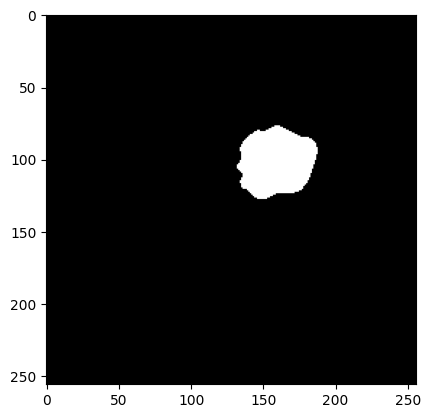

In [11]:
test_image = cv2.imread(r"F:\FYP\FYP\FigshareDataset\training\masks\2.png",0)
test_image = cv2.resize(test_image,(256,256))
test_image = (test_image/255).astype(int).astype(float)
print(np.unique(test_image,return_counts=True))
plt.imshow(test_image, cmap='gray')
plt.show()

# Creating the data generator

In [ ]:
# def load_img(img_dir, img_list):
#     images=[]
#     for i, image_name in enumerate(img_list):
#         if (image_name.split('.')[1] == 'npy'):
#             image = np.load(img_dir+image_name)
#             # print("Image - ",image.shape)
#             images.append(image)
#     images = np.array(images)

#     return(images)



def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(img_dir+"/"+image_name,0)
            image = cv2.resize(image,(256,256))
            images.append(image)
    images = np.array(images)

    return(images)


def load_msk(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'png'):
            image = (cv2.imread(img_dir+"/"+image_name,0)/255).astype(float)
            # print(np.unique(image))
            image = cv2.resize(image,(256,256))
            # print("before - ",image.shape)
            image = to_categorical(image, num_classes=2)
            # print("After - ",image.shape)
            images.append(image)
    images = np.array(images)

    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_msk(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size

# Making the data generator

In [ ]:
train_img_dir = r"F:\FYP\FYP\FigshareDataset\images"
train_mask_dir = r"F:\FYP\FYP\FigshareDataset\masks"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

# val_img_dir = "/content/drive/MyDrive/BRATS_train_data/X_validation/"
# val_mask_dir = "/content/drive/MyDrive/BRATS_train_data/Y_validation/"
# val_img_list=os.listdir(val_img_dir)
# val_mask_list = os.listdir(val_mask_dir)

In [ ]:
batch_size = 8

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

# val_img_datagen = imageLoader(val_img_dir, val_img_list,
#                                 val_mask_dir, val_mask_list, batch_size)

# Verifying the generator

In [ ]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

# Visualizing the loaded images

In [ ]:
import random
data_point = random.randint(0, batch_size)
# data_point = 3

original_labels = np.expand_dims(msk[data_point,:,:,:], axis=0)
original_labels = np.argmax(original_labels, axis=3)
print(original_labels.shape)


plt.subplot(121)
plt.imshow(img[data_point,:], cmap='gray')
plt.title('Scan')
plt.subplot(122)
plt.imshow(original_labels[0,:,:], cmap='gray')
plt.title('Complete label')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
plt.show()

# Defining 3 UNET architectures

In [ ]:
# https://youtu.be/L5iV5BHkMzM
"""

Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf

Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)

Note: Batch normalization should be performed over channels after a convolution,
In the following code axis is set to 3 as our inputs are of shape
[None, height, width, channel]. Channel is axis=3.

Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same",kernel_initializer='he_normal',activation = "relu")(x)
    conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same",kernel_initializer='he_normal',activation = "relu")(conv)
    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same',kernel_initializer='he_normal')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same',kernel_initializer='he_normal')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same',kernel_initializer='he_normal')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same',kernel_initializer='he_normal')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same',kernel_initializer='he_normal')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn




def UNet(input_shape, NUM_CLASSES=2, dropout_rate=0.4, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 16 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, 0.3, batch_norm)#Conv2D > dropout > Conv2D
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, 0.3, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, 0.4, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, 0.4, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, 0.5, batch_norm)

    # Upsampling layers

    #up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.Conv2DTranspose(8*FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, 0.4, batch_norm)
    # UpRes 7

    up_32 = layers.Conv2DTranspose(4*FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, 0.4, batch_norm)
    # UpRes 8

    up_64 = layers.Conv2DTranspose(2*FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, 0.3, batch_norm)
    # UpRes 9

    up_128 = layers.Conv2DTranspose(FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, 0.3, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1),kernel_initializer='he_normal',activation = 'sigmoid')(up_conv_128)
    #conv_final = layers.BatchNormalization(axis=3)(conv_final)
    #conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Attention_UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.4, batch_norm=False):
    '''
    Attention UNet,

    '''
    # network structure
    FILTER_NUM = 16 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, 0.3, batch_norm)#Conv2D > dropout > Conv2D
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, 0.3, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, 0.4, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, 0.4, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, 0.5, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.Conv2DTranspose(8*FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, 0.4, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.Conv2DTranspose(4*FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, 0.4, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.Conv2DTranspose(2*FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, 0.3, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.Conv2DTranspose(FILTER_NUM, (2, 2), strides=(2, 2), padding='same')(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, 0.3, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1),kernel_initializer='he_normal',activation = 'softmax')(up_conv_128)
    #conv_final = layers.BatchNormalization(axis=3)(conv_final)
    #conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    model.summary()
    return model

def Attention_ResUNet(input_shape, NUM_CLASSES=4, dropout_rate=0.4, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    model.summary()
    return model

In [ ]:
# input_shape = (240,240,4)
# # UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True)
# # Attention_UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True)
# Attention_ResUNet(input_shape, NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True)

In [ ]:
###############################################################
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_masks_reshaped_encoded),
#                                                  train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)

# Defining loss functions

In [ ]:
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

# # Typical tf.keras API usage
# import tensorflow as tf
# from focal_loss import BinaryFocalLoss,SparseCategoricalFocalLoss

In [ ]:
# import segmentation_models_3D as sm
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf

@keras.saving.register_keras_serializable()
class FocalLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.25, gamma=4.0):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma

  def call(self, y_true, y_pred):
    """
    Inputs and targets should be of shape (batch_size, num_classes, height, width)
    """

    # Calculate the cross-entropy loss
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Calculate the scaling factor
    pt = tf.math.exp(-ce_loss)
    #scaling_factor = self.alpha * (1 - pt) ** self.gamma
    scaling_factor = (1 - pt) ** self.gamma

    # Calculate the Focal loss
    focal_loss = scaling_factor * ce_loss

    # Return the average Focal loss over the batch
    return tf.reduce_mean(focal_loss)


# Creating a callback

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/MyDrive/models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Calculate the number of batches per epoch
import math
n_batches = 3000 / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=10*n_batches)


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH  =  256
IMG_CHANNELS = 1


input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)


model = UNet(input_shape, NUM_CLASSES=2, dropout_rate=0.4, batch_norm=False)
# model.compile(optimizer='adam', loss= tf.keras.losses.CategoricalFocalCrossentropy(alpha=1,gamma=4), metrics=[jacard_coef])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
# val_steps_per_epoch = len(val_img_list)//batch_size

In [ ]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    epochs=103,
                    # validation_data=val_img_datagen,
                    # validation_steps=val_steps_per_epoch,
                    shuffle=False,
                    # callbacks=[cp_callback],
                    )


In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
for i in history.history.items():
  print(i)

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
np.save("/content/drive/MyDrive/models/training_loss.npy",np.array(loss))
np.save("/content/drive/MyDrive/models/val_loss.npy",np.array(val_loss))
np.save("/content/drive/MyDrive/models/training_jaccard.npy",np.array(acc))
np.save("/content/drive/MyDrive/models/val_jaccard.npy",np.array(val_acc))
np.save("/content/drive/MyDrive/models/epochs.npy",range(1, len(np.array(loss)) + 1))

In [ ]:
os.listdir(checkpoint_dir)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
# Create a new model instance

model = Attention_UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.2, batch_norm=True)
model.compile(optimizer='adam', loss= FocalLoss(), metrics=[jacard_coef])

# Load the previously saved weights
model.load_weights("/content/drive/MyDrive/models/cp-0041.ckpt")

In [ ]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    epochs=100,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    shuffle=False,
                    callbacks=[cp_callback],)

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
img, msk = val_img_datagen.__next__()
import random
test_img_number = random.randint(0, len(img))#6 is good
test_img = img[test_img_number]
ground_truth=msk[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
print(prediction.shape)
print(ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray') #only the first channel is displayed

plt.subplot(232)
plt.title('Original Label')
displayed_label = np.argmax(ground_truth, axis=2)
plt.imshow(displayed_label, cmap='jet')

plt.subplot(233)
plt.title('Predicted Label')
plt.imshow(predicted_img, cmap='jet')
plt.show()


In [ ]:
print(test_img_number)

In [ ]:
model.save('/content/drive/MyDrive/models/my_model.keras')